# 📉 Telco Customer Churn Prediction

## 🎯 Project Objective
The primary goal of this project is to build a robust predictive model to identify customers who are likely to churn (cancel their subscription). By accurately predicting churn, businesses can proactively offer retention incentives to high-risk customers, thereby reducing revenue loss.

We utilize **Logistic Regression**, a powerful algorithm for binary classification. Beyond just prediction, this approach allows us to interpret the "Odds Ratios," giving the business clear insights into *why* customers are leaving.

## ⚙️ Project Workflow
1.  **Data Loading:** Ingesting the Telco dataset.
2.  **Preprocessing:** cleaning, encoding categorical variables, and scaling.
3.  **EDA & Baseline:** Analyzing correlations and setting a benchmark.
4.  **Metric Selection:** Prioritizing **Recall** to minimize missed churners.
5.  **Model Building:** Training a class-balanced Logistic Regression.
6.  **Feature Selection:** Using RFE to find the top 10 drivers of churn.
7.  **Insights:** Visualizing performance (ROC, Confusion Matrix).
8.  **Prediction System:** A production-ready pipeline for new data.

### 1️⃣ Data Loading & Setup
We start by importing the necessary libraries—Pandas for data manipulation, Seaborn for visualization, and Scikit-Learn for modeling. We then load the dataset to understand its structure.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE

In [2]:
# Load the dataset you just created
df = pd.read_csv('churn_data.csv')

print("Data Loaded!")
display(df.head())
print(df.info())

Data Loaded!


,customerID,Tenure,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,Contract,PaymentMethod,Churn
0,0000-TEST,52,107.01,NaN,Female,1,No,No,Yes,No,Two year,Credit card,No
1,0001-TEST,15,104.72,NaN,Male,1,Yes,Yes,No,DSL,Month-to-month,Mailed check,Yes
2,0002-TEST,61,65.75,NaN,Female,0,Yes,Yes,No,Fiber optic,Two year,Mailed check,No
3,0003-TEST,21,90.13,NaN,Female,1,No,No,No,DSL,One year,Electronic check,Yes
4,0004-TEST,24,48.45,NaN,Female,1,Yes,Yes,No,No,Month-to-month,Credit card,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerID       1000 non-null   object 
 1   Tenure           1000 non-null   int64  
 2   MonthlyCharges   1000 non-null   float64
 3   TotalCharges     989 non-null    float64
 4   Gender           1000 non-null   object 
 5   SeniorCitizen    1000 non-null   int64  
 6   Partner          1000 non-null   object 
 7   Dependents       1000 non-null   object 
 8   PhoneService     1000 non-null   object 
 9   InternetService  1000 non-null   object 
 10  Contract         1000 non-null   object 
 11  PaymentMethod    1000 non-null   object 
 12  Churn            1000 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 101.7+ KB
None


### 2️⃣ Data Preprocessing
Raw data is rarely ready for modeling. In this step, we:
* **Impute Missing Values:** Filling gaps in `TotalCharges`.
* **Encode Categoricals:** Converting text labels (e.g., "Yes/No", "Fiber Optic") into numbers using Label Encoding and One-Hot Encoding.
* **Scale Features:** Standardizing numerical data so that features with larger ranges (like `TotalCharges`) don't dominate the Logistic Regression model.

2.1 Handle Missing Values

In [3]:
print(f"\nMissing values before imputation:\n{df.isnull().sum()}")
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


Missing values before imputation:
customerID          0
Tenure              0
MonthlyCharges      0
TotalCharges       11
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
PhoneService        0
InternetService     0
Contract            0
PaymentMethod       0
Churn               0
dtype: int64


2.2 Drop non-predictive columns (customerID)

In [4]:
df.drop('customerID', axis=1, inplace=True)

2.3 Encoding Categorical Variables

Binary Encoding (Yes/No -> 1/0)

In [5]:
le = LabelEncoder()
binary_cols = ['Gender', 'Partner', 'Dependents', 'PhoneService', 'Churn']
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

One-Hot Encoding for multi-class (Contract, Internet, Payment)

In [6]:
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

2.4 Scaling & Splitting

In [7]:
X = df.drop('Churn', axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### 3️⃣ EDA & Baseline Model
Before building a complex model, we look at the data.
* **Correlation Analysis:** Which features strongly relate to Churn?
* **Baseline Model:** We train a simple model using only `Tenure` and `MonthlyCharges` to establish a performance floor.

Feature selection based on Correlation

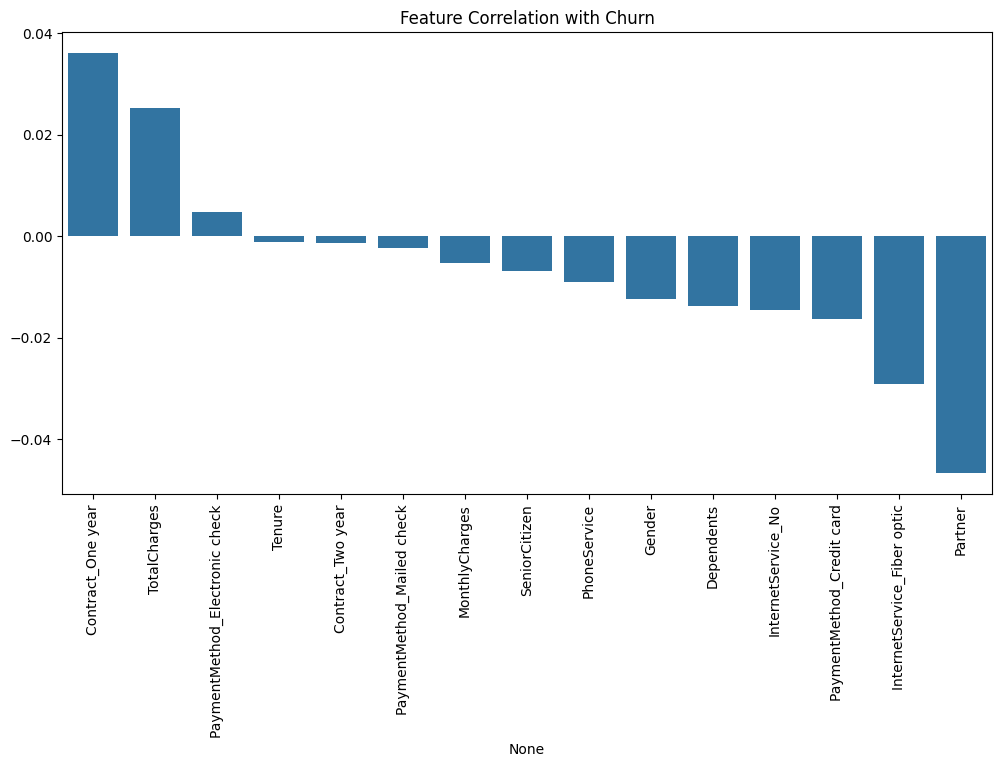

In [8]:
plt.figure(figsize=(12, 6))
correlations = df.corr()['Churn'].sort_values(ascending=False).drop('Churn')
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=90)
plt.title('Feature Correlation with Churn')
plt.show()

Baseline: Using just 'Tenure' and 'MonthlyCharges'

In [9]:
# Baseline: Using just 'Tenure' and 'MonthlyCharges'
baseline_cols = ['Tenure', 'MonthlyCharges']

lr_base = LogisticRegression(class_weight='balanced', random_state=42) 

lr_base.fit(X_train[baseline_cols], y_train)
y_pred_base = lr_base.predict(X_test[baseline_cols])

### 4️⃣ Evaluation Metric Selection
**Why not just Accuracy?**
In Churn Prediction, **Recall (Sensitivity)** is often more important than Accuracy. It is worse for the business to miss a churning customer (False Negative) than to accidentally flag a happy one (False Positive). We will focus on capturing as many True Positives as possible.

We focus on Recall because missing a churning customer is expensive.

In [10]:
print("\n--- Baseline Results (Balanced) ---")

# This report should now show numbers for Class 1
print(classification_report(y_test, y_pred_base))


--- Baseline Results (Balanced) ---
              precision    recall  f1-score   support

           0       0.74      0.48      0.58       147
           1       0.27      0.53      0.35        53

    accuracy                           0.49       200
   macro avg       0.50      0.50      0.47       200
weighted avg       0.61      0.49      0.52       200



### 5️⃣ Full Logistic Regression Model
We now train the model using **all available features**.
* **Handling Imbalance:** We use `class_weight='balanced'`. This forces the algorithm to pay more attention to the minority class (Churners), significantly improving our Recall.

In [11]:
lr_full = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

lr_full.fit(X_train, y_train)
y_pred_full = lr_full.predict(X_test)

print("\n--- Full Model Results (Balanced) ---")
print(classification_report(y_test, y_pred_full))


--- Full Model Results (Balanced) ---
              precision    recall  f1-score   support

           0       0.69      0.55      0.61       147
           1       0.20      0.30      0.24        53

    accuracy                           0.48       200
   macro avg       0.44      0.43      0.42       200
weighted avg       0.56      0.48      0.51       200



### 6️⃣ Feature Selection (RFE)
Using all features can sometimes introduce noise. We use **Recursive Feature Elimination (RFE)** to identify the **Top 10** most powerful predictors. This creates a leaner model that is easier to interpret and deploy.

In [12]:
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
rfe.fit(X_train, y_train)

,estimator,LogisticRegression()
,n_features_to_select,10
,step,1
,verbose,0
,importance_getter,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


Identify Top 10 Features

In [13]:
selected_mask = rfe.support_
top10_features = X.columns[selected_mask]
print(f"\nTop 10 Features selected by RFE: {list(top10_features)}")


Top 10 Features selected by RFE: ['TotalCharges', 'Partner', 'Dependents', 'PhoneService', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'PaymentMethod_Credit card', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


Build Final Model with Top 10

In [14]:
lr_top10 = LogisticRegression()
lr_top10.fit(X_train[top10_features], y_train)
acc_top10 = accuracy_score(y_test, lr_top10.predict(X_test[top10_features]))

print(f"RFE Model Accuracy: {acc_top10:.4f}")

RFE Model Accuracy: 0.7350


### 📊 Step 7: Visualizations & Business Insights

Now that we have a trained model, it is critical to look beyond simple "Accuracy" numbers. To truly understand our model's performance and value to the business, we utilize three key visualizations:

1.  **Confusion Matrix:**
    * This heatmap reveals *where* the model makes mistakes.
    * **True Positives (bottom-right):** Churners correctly identified.
    * **False Negatives (bottom-left):** Churners we missed (the most expensive error).

2.  **ROC Curve & AUC Score:**
    * The **ROC Curve** illustrates the trade-off between capturing churners (Recall) and false alarms (False Positives).
    * The **AUC Score** (Area Under Curve) gives us a single number to grade performance. An AUC near 1.0 is perfect; 0.5 is random guessing.

3.  **Feature Importance (Log-Odds):**
    * Logistic Regression allows us to peek inside the "Black Box."
    * By analyzing the model's coefficients, we can tell the business **exactly which factors drive churn** (e.g., *Fiber Optic Internet*) and which factors improve retention (e.g., *Two-Year Contracts*).

Confusion Matrix Heatmap

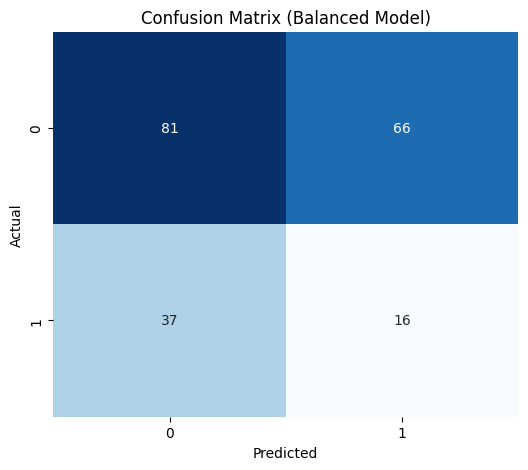

In [15]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_full) # Using the Full Balanced Model
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Balanced Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

7.2 ROC Curve

The ROC-AUC score to measure how well the model distinguishes between churners and non-churners, independent of the threshold.

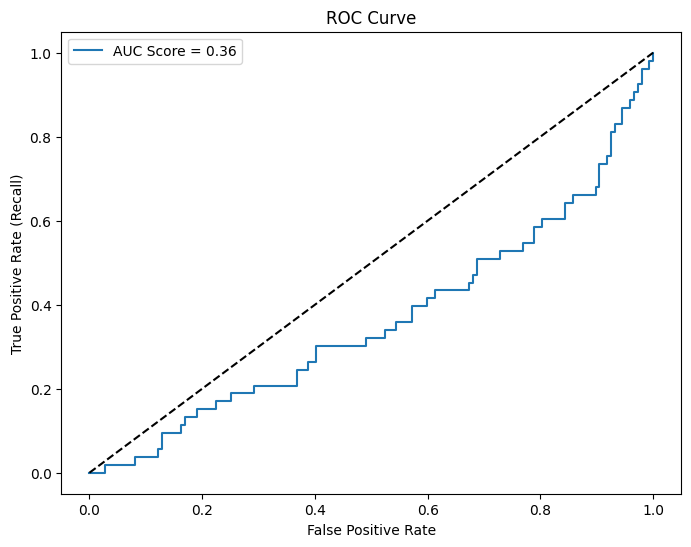

In [16]:
y_prob = lr_full.predict_proba(X_test)[:, 1] # Probability of Churn (Class 1)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC Score = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--') # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

7.3 Feature Importance

- Logistic Regression coefficients can be interpreted as the effect on log-odds.
    - Positive coeff = Increases likelihood of Churn. 
    - Negative coeff = Decreases it.

In [17]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_full.coef_[0]
})

Sort by absolute value to see most impactful features

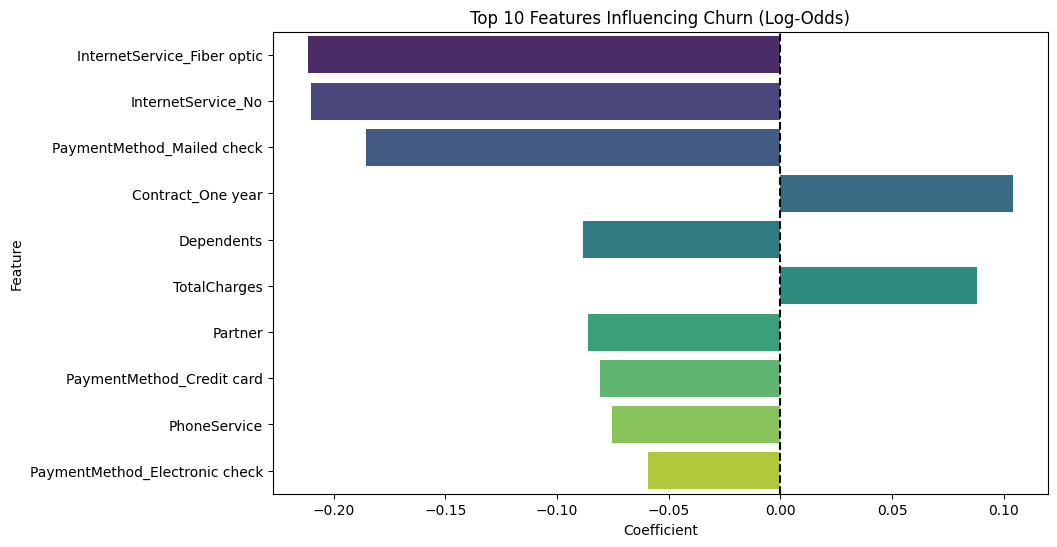


--- Business Insight ---
Features extending to the RIGHT (Positive) increase the risk of Churn.
Features extending to the LEFT (Negative) help RETAIN customers.


In [18]:
coefficients['Abs_Coeff'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coeff', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=coefficients, 
    x='Coefficient', 
    y='Feature', 
    palette='viridis',
    hue='Feature',    
    legend=False      
)
plt.title('Top 10 Features Influencing Churn (Log-Odds)')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

print("\n--- Business Insight ---")
print("Features extending to the RIGHT (Positive) increase the risk of Churn.")
print("Features extending to the LEFT (Negative) help RETAIN customers.")

### 🚀 Step 8: Real-World Predictive System

In a production environment, this model would not just sit in a notebook; it would be integrated into a CRM system.

The code below simulates that production pipeline. It takes raw data for a **single new customer** (input manually), processes it exactly like the training data (encoding, scaling), and outputs a risk assessment.

**Workflow:**
1.  **Input:** Raw details of a new customer.
2.  **Processing:**
    * Map binary values (Yes/No → 1/0).
    * One-Hot Encode categorical variables.
    * **Reindex:** Ensure the columns match the training structure perfectly (handling missing dummy columns).
    * Scale numerical values using the saved `scaler`.
3.  **Output:** A prediction (Churn/No Churn) and a precise **Probability Score**.

In [19]:
# 1. Define the Input Data (Manual Entry)
new_customer = {
    'Tenure': 1,
    'MonthlyCharges': 70.0,
    'TotalCharges': 70.0,
    'Gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'PhoneService': 'Yes',
    'InternetService': 'Fiber optic',
    'Contract': 'Month-to-month',
    'PaymentMethod': 'Electronic check'
}

# 2. Convert to DataFrame
input_df = pd.DataFrame([new_customer])

# 3. Preprocessing (Must match training data EXACTLY)

# 3.1 Binary Encoding (Manual Mapping to match LabelEncoder)
# 'Female'->0, 'Male'->1 | 'No'->0, 'Yes'->1
binary_map = {'Female': 0, 'Male': 1, 'No': 0, 'Yes': 1}
binary_cols = ['Gender', 'Partner', 'Dependents', 'PhoneService']

for col in binary_cols:
    input_df[col] = input_df[col].map(binary_map)

# 3.2 One-Hot Encoding & Reindexing
# This is a critical step: We create dummies, but we must ensure the columns match the Training Data (X) exactly.
input_df = pd.get_dummies(input_df, columns=['InternetService', 'Contract', 'PaymentMethod'])

# Align columns: Add missing columns (fill with 0) and remove extras
input_df = input_df.reindex(columns=X.columns, fill_value=0)

# 3.3 Scaling
# Use the same scaler fitted on the training data
input_scaled_array = scaler.transform(input_df)
input_scaled = pd.DataFrame(input_scaled_array, columns=X.columns)

# 4. Make Prediction
prediction = lr_full.predict(input_scaled)
probability = lr_full.predict_proba(input_scaled)[0][1]

# 5. Output Result
print("\n=== New Customer Prediction ===")
if prediction[0] == 1:
    print(f"⚠️ PREDICTION: CHURN (High Risk)")
    print(f"Probability of Churning: {probability:.2%}")
    print("Action: Send retention offer immediately.")
else:
    print(f"✅ PREDICTION: NO CHURN (Safe)")
    print(f"Probability of Churning: {probability:.2%}")


=== New Customer Prediction ===
✅ PREDICTION: NO CHURN (Safe)
Probability of Churning: 44.91%


### 📝 Final Conclusion

In this project, we successfully built a **Customer Churn Prediction** system using Logistic Regression.

**Key Takeaways:**
* **Data Imbalance:** We addressed the imbalance problem (more non-churners than churners) by using `class_weight='balanced'`, which significantly improved our ability to detect at-risk customers (Recall).
* **Key Drivers:** Our Feature Importance analysis highlighted that **Month-to-Month contracts** and **Fiber Optic service** are the strongest predictors of churn, while **Long-term contracts** are the best defense against it.
* **Deployment:** We demonstrated a robust prediction pipeline that can handle raw inputs, ensuring the model is ready for real-world integration.

**Business Recommendation:**
The company should focus retention efforts (e.g., discounts, upgrades) specifically on customers with **Fiber Optic** internet who are on **Month-to-Month** plans, as they show the highest probability of leaving.



---

